<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces  <br></b> 
    </font>
     <br>
     <font size="3">
        Implementation notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Implementation__

## __Install components__

In [ ]:
!pip install editdistance
!pip install pandas_read_xml
!pip install requests

## __Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime

plt.style.use('seaborn-whitegrid') # plot style

## __Model__









In [16]:
class RankedWTAHash:

    def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', prototypesFilterThr=None, ngramms=3, similarityThreshold=None, maxOnly=None,earlyStop=0):
        '''
          Constructor
        '''
        self.max_numberOf_clusters = max_numberOf_clusters
        self.pairDictionary = dict()
        self.max_editDistance = max_editDistance
        self.windowSize = windowSize
        self.S_set = None
        self.S_index = None
        self.similarityThreshold = similarityThreshold
        self.maxOnly = maxOnly
        self.metric = metric
        self.min_numOfNodes = min_numOfNodes
        self.similarityVectors = similarityVectors
        self.number_of_permutations = number_of_permutations
        self.distanceMetric = distanceMetric
        self.distanceMetricEmbedding = distanceMetricEmbedding
        self.ngramms = ngramms
        self.jaccard_withchars =  jaccard_withchars
        self.prototypesFilterThr = prototypesFilterThr
        self.earlyStop = earlyStop
        self.selectionVariance = None
        self.numOfComparisons = 0

    def fit(self, X):
        """
          Fit the classifier from the training dataset.
          Parameters
          ----------
          X : Training data.
          
          Returns
          -------
          self : The fitted classifier.
        """
        print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

        if isinstance(X, list):
            input_strings = X
        else:
            input_strings = list(X)

        self.initialS_set = np.array(input_strings,dtype=object)
        self.S_set = np.array(input_strings,dtype=object)
        if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(self.S_set[i]), n=self.ngramms))
        elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:
            for i in range(0,len(input_strings)):
                self.S_set[i] = set(nltk.ngrams(self.S_set[i], n=self.ngramms))

        self.S_index = np.arange(0,len(input_strings),1)

        # print("\n\nString positions are:")
        # print(self.S_index)
        # print("\n")

        print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
        print("\n-> Finding prototypes and representatives of each cluster:")
        prototypes_time = time.time()
        self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
        print("\n- Prototypes selected")
        self.embeddingDim = self.prototypeArray.size
        print(self.prototypeArray)
        heatmapData = []
        for pr in self.prototypeArray:
            print(pr," -> ",self.initialS_set[pr])
            heatmapData.append(self.S_set[pr])
            
        if self.selected_numOfPrototypes > 2:
            self.selectionVariance = myHeatmap(self.prototypeArray,self.metric,self.EditDistance)
            print("\n- Mean variance in prototype selection: ",self.selectionVariance )
        print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
        prototypes_time = time.time() - prototypes_time
        print("\n# Finished in %.6s secs" % (prototypes_time))
        print("\n")

        if self.earlyStop==1:
            return self

        print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
        print("\n-> Creating Embeddings:")
        embeddings_time = time.time()
        self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
        print("- Embeddings created")
        print(self.Embeddings)
        embeddings_time = time.time() - embeddings_time
        print("\n# Finished in %.6s secs" % (embeddings_time))
        print("\n")

        if self.earlyStop==2:
            return self

        print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
        print("\n-> Creating WTA Buckets:")
        wta_time = time.time()
        self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize, self.number_of_permutations)
        print("- WTA buckets: ")
        for key in self.buckets.keys():
            print(key," -> ",self.buckets[key])
        print("\n- WTA number of buckets: ", len(self.buckets.keys()))
        print("\n- WTA RankedVectors after permutation:")
        print(self.rankedVectors)
        wta_time = time.time() - wta_time
        print("\n# Finished in %.6s secs" % (wta_time))
        print("\n")
        
#         for key in self.buckets.keys():
#             if len(self.buckets[key]) > 216:
#                 self.earlyStop=3
                
        
        if self.earlyStop==3:
            return self

        print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
        print("\n-> Similarity checking:")
        if len(self.buckets.keys()) < 5:
            self.earlyStop=5
            return self

        similarity_time = time.time()

        if self.similarityVectors == 'ranked':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        elif self.similarityVectors == 'initial':
            self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
        else:
            warnings.warn("similarityVectors: Available options are: ranked,initial")
        #     print("- Similarity matrix (all values compared):")
        #     print(self.similarityProb_matrix)
        print("- Similarity mapping in a matrix")
        print(self.mapping_matrix)
        similarity_time = time.time() - similarity_time
        print("\n# Finished in %.6s secs" % (similarity_time))
        print("\n#####################################################################\n#                    .~         End        ~.                          #\n#####################################################################\n")

        return self

    def EditDistance(self, str1,str2,verbose=False):
        if verbose:
            if str1 == None:
                print("1")
            elif str2 == None:
                print("2")
            print("-> "+str(str1))
            print("--> "+str(str2))
            print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))

        if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
            return self.pairDictionary[(str1,str2)]
        else:
            if self.distanceMetric == 'edit':
                distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
            elif self.distanceMetric == 'jaccard':
                distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
                        # jaccard because we want DISSIMILARITY
            else:
                warnings.warn("Available metrics for space creation: edit, jaccard ")
            self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
            return distance

    #####################################################################
    # 1. Prototype selection algorithm                                  #
    #####################################################################

    '''
    Clustering_Prototypes(S,k,d,r,C) 
    The String Clustering and Prototype Selection Algorithm
    is the main clustering method, that takes as input the intial strings S, 
    the max number of clusters to be generated in k,
    the maximum allowable distance of a string to join a cluster in var d
    and returns the prototype for each cluster in array Prototype
    '''
    def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):

        # ----------------- Initialization phase ----------------- #
        i = 0
        j = 0
        C = np.empty([S.size], dtype=int)
        r = np.empty([2,k],dtype=object)

        Clusters = [ [] for l in range(0,k)]

        for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
            while j < k :       # iteration through clusters, for all clusters
                if r[0][j] == None:      # case empty first representative for cluster j
                    r[0][j] = S[i]   # init cluster representative with string i
                    C[i] = j         # store in C that i-string belongs to cluster j
                    Clusters[j].append(S[i])
                    break
                elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative
                    r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                    C[i] = j
                    Clusters[j].append(S[i])
                    break
                else:
                    j += 1
            i += 1

        # ----------------- Prototype selection phase ----------------- #

        Projections = np.empty([k],dtype=object)
        Prototypes = np.empty([k],dtype=int)
        sortedProjections = np.empty([k],dtype=object)
        Projections = []
        Prototypes = []
        sortedProjections = []

        if verbose:
            print("- - - - - - - - -")
            print("Cluster array:")
            print(C)
            print("- - - - - - - - -")
            print("Represantatives array:")
            print(r)
            print("- - - - - - - - -")
            print("Clusters:")
            print(Clusters)
            print("- - - - - - - - -")

        new_numofClusters = k
        prototype_index = 0
        for j in range(0,k,1):
            if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
                new_numofClusters-=1
                continue

            Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))
            sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
            Prototypes.append(self.Median(sortedProjections[prototype_index]))

            prototype_index += 1

        Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)

        return np.array(Prototypes),new_numofClusters


    def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):

        distances_vector = dict()

        if len(clusterSet) > 2:
            rep_distance     = self.EditDistance(right_rep,left_rep)

            for str_inCluster in range(0,len(clusterSet)):
                if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
                    # print(clusterSet[str_inCluster],right_rep,left_rep)
                    right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
                    left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])

                    if rep_distance == 0:
                        distances_vector[clusterSet[str_inCluster]] = 0
                    else:
                        distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
                        distances_vector[clusterSet[str_inCluster]] = distance

        else:
            if left_rep != None and right_rep == None:
                distances_vector[left_rep] = left_rep
            elif right_rep != None and left_rep == None:
                distances_vector[right_rep] = right_rep
            elif left_rep == None and right_rep == None:
                return None
            elif left_rep != None and right_rep != None:
                distances_vector[right_rep] = right_rep
                distances_vector[left_rep]  = left_rep
                
        return distances_vector

    def Median(self, distances):
        '''
        Returns the median value of a vector
        '''
        keys = list(distances.keys())
        if keys == 1:
            return keys[0]

        # print(distances)
        keys = list(distances.keys())
        # print(keys)
        median_position = int(len(keys)/2)
        # print(median_position)
        median_value = keys[median_position]

        return median_value

    def optimize_clusterSelection(self,Prototypes,numOfPrototypes):

        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.prototypesFilterThr:
                    notwantedPrototypes.append(Prototypes[pr_2])

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))

        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)


    #####################################################################
    #       2. Embeddings based on the Vantage objects                  #
    #####################################################################

    '''
    CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
    '''
    def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):

        # ------- Distance computing ------- #
        vectors = []
        for s in tqdm(range(0,S.size)):
            string_embedding = []
            for p in range(0,VantageObjects.size):
                if VantageObjects[p] != None:
                    #                   print("-",VantageObjects[p])
                    string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))

            # --- Ranking representation ---- #
            ranked_string_embedding = stats.rankdata(string_embedding, method='dense')

            # ------- Vectors dataset ------- #
            vectors.append(ranked_string_embedding)

        return np.array(vectors)


    '''
    DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
    '''
    def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):

        if distanceMetricEmbedding == 'l_inf':
            max_distance = None

            for pp in range(0,VantageObjects.size):
                if VantageObjects[pp] != None:
                    string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                    VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                    abs_diff = abs(string_distance-VO_distance)

                    # --- Max distance diff --- #
                    if max_distance == None:
                        max_distance = abs_diff
                    elif abs_diff > max_distance:
                        max_distance = abs_diff
            return max_distance

        elif distanceMetricEmbedding == 'edit':
            return self.EditDistance(S[s],VantageObjects[p])
        elif distanceMetricEmbedding == 'jaccard':
            return jaccard_distance(S[s],VantageObjects[p])
        elif distanceMetricEmbedding == 'euclid_jaccard':
            return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
        elif distanceMetricEmbedding == 'euclidean':
            return euclidean(S[s],VantageObjects[p])
        else:
            warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")


    def dropNone(array):
        array = list(filter(None, list(array)))
        return np.array(array)


    #####################################################################
    #                 3. Similarity checking                            #
    #####################################################################

    def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]
        mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
        self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
        mapping = {}
        
        self.numOfComparisons = 0
        # Loop for every bucket
        for bucketid in tqdm(buckets.keys()):
            bucket_vectors = buckets[bucketid]
            numOfVectors = len(bucket_vectors)

            print(bucket_vectors)
            # For every vector inside the bucket
            for v_index in range(0,numOfVectors,1):
                v_vector_id = bucket_vectors[v_index]
                # Loop to all the other
                for i_index in range(v_index+1,numOfVectors,1):
                    i_vector_id = bucket_vectors[i_index]
                    if vectorDim == 1:
                        warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
                        metric = 'kendal'
                    
                    self.numOfComparisons+=1
                    
                    if metric == None or metric == 'kendal':  # Simple Kendal tau metric
                        similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'customKendal':  # Custom Kendal tau
                        numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                        similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
                    elif metric == 'jaccard':
                        similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
                    elif metric == 'cosine':
                        similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
                    elif metric == 'pearson':
                        similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearman':
                        similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'spearmanf':
                        similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'hamming':
                        similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
                    elif metric == 'kruskal':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'ndcg_score':
                        similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'rbo':
                        similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'wta':
                        similarity_prob = WTA_similarity(vectors[v_vector_id], vectors[i_vector_id])
                    elif metric == 'mannwhitneyu':
                        if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
                            similarity_prob=1.0
                        else:
                            _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
                    else:
                        warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")


                    self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob

                    if similarity_prob > threshold:
                        if v_vector_id not in mapping.keys():
                            mapping[v_vector_id] = []
                        mapping[v_vector_id].append(i_vector_id)  # insert into mapping
                        mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
                        mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix


        return mapping, np.triu(mapping_matrix)

    #####################################################################
    #                        4. WTA Hashing                             #
    #####################################################################

    def WTA(self,vectors,K, number_of_permutations):
        '''
          Winner Take All hash - Yagnik
          .............................
    
          K: window size
        '''
        newVectors = []
        buckets = dict()

        numOfVectors = vectors.shape[0]
        vectorDim    = vectors.shape[1]

        if vectorDim < K:
            K = vectorDim
            warnings.warn("Window size greater than vector dimension")

        C = np.zeros([numOfVectors,number_of_permutations], dtype=int)

        permutation_dimension = vectorDim
        for permutation_index in range(0,number_of_permutations,1):
            theta = np.random.permutation(permutation_dimension)
            i=0;j=0;
            for v_index in range(0,numOfVectors,1):
                if permutation_index == 0:
                    X_new = self.permuted(vectors[v_index],theta)
                    newVectors.append(X_new)
                else:
                    X_new = self.permuted(vectors[v_index],theta)
                    newVectors[v_index] = X_new

                C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
                i+=1
            

        for c,i in zip(C,range(0,numOfVectors,1)):
            buckets = self.bucketInsert(buckets,str(c),i)

        return C,buckets,np.array(newVectors,dtype=np.intp)


    def permuted(self,vector,permutation):
        permuted_vector = [vector[x] for x in permutation]

        return permuted_vector


    def bucketInsert(self,buckets,bucket_id,item):
        if bucket_id not in buckets.keys():
            buckets[bucket_id] = []
        buckets[bucket_id].append(item)

        return buckets


### Various similarity metrics to check
These functions are for the similarity checking phase.

#### Spearman footrule distance

In [ ]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    
    return sdist/normalizer

#### Ravi Kumar generalized Kendall Tau

In [ ]:
def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall

#### Rank Biased Overlap (RBO) 
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

In [ ]:
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

#### Winner Takes All proposed 

In [ ]:
def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0


# __Evaluation__

## Load data from Drive in Colab

In [ ]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [3]:
CORA_groundTruth = os.path.abspath("data/coraIdDuplicates.csv")
CORA = os.path.abspath("data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA = pd.read_csv(CORA,sep='|')
CORA

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,0,"los alamitos, ca:","p. auer, n. cesa-bianchi, y. freund, and r. e....",NaN,NaN,NaN,NaN,pp. 322-331.,"ieee computer society press,",'gambling in a rigged casino: the adversarial ...,in proc. 36th annual symposium on foundations ...,NaN,"1995,",NaN
1,1,NaN,"a. blum, m. furst, m. j. kearns, and richard j...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
2,2,NaN,"avrim blum, merrick furst, michael kearns, and...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
3,3,NaN,"avrim blum, merrick furst, michael kearns, and...","in douglas r. stinson, editor,",NaN,NaN,lecture notes in computer science no. 773.,pages 278-291.,"springer,",cryptographic primitives based on hard learnin...,"proc. crypto 93,",NaN,1994.,NaN
4,4,NaN,"a. blum, m. furst, m. kearns, r. lipton.",NaN,NaN,NaN,NaN,NaN,NaN,cryptographic primitives based on hard learnin...,"crypto,",NaN,1993.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,NaN,robert e. schapire and yoram singer.,NaN,NaN,NaN,NaN,NaN,NaN,improved boosting algorithms using confidence-...,in proceedings of the eleventh annual conferen...,NaN,1998.,NaN
1291,1291,NaN,"schapire, r. e., freund, y., bartlett, p., & l...",NaN,NaN,NaN,annals of statistics (to appear).,NaN,NaN,boosting the margin: a new explanation for the...,NaN,NaN,(1998).,NaN
1292,1292,NaN,robert e. schapire and yoram singer. boostexter:,NaN,NaN,NaN,NaN,NaN,NaN,a system for multiclass multi-label text categ...,"unpublished manuscript,",NaN,1998.,NaN
1293,1293,NaN,robert e. schapire yoram singer.,NaN,NaN,NaN,submitted for publication. 17,NaN,NaN,improved boosting algorithms using confidence-...,NaN,NaN,NaN,NaN


In [4]:
CORA_groundTruth

,id1,id2
0,987,990
1,987,991
2,987,988
3,987,989
4,987,994
...,...,...
17179,206,210
17180,206,211
17181,206,212
17182,206,213


#### CENSUS

In [ ]:
CENSUS_groundTruth = os.path.abspath("data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
CENSUS

In [ ]:
CENSUS_groundTruth

#### CDDB

In [ ]:
CDDB_groundTruth = os.path.abspath("data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
CDDB

In [ ]:
CDDB_groundTruth

#### DBLP - ACM

In [ ]:
ACM = os.path.abspath("ACM.csv")
DBLP = os.path.abspath("DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [ ]:
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

### HeatMap

In [5]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(10,10))
    corr = np.corrcoef(matrix)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()
    return matrix.mean()

## __CORA Evaluation__

### Text Preprocess

In [6]:
def preprocess(row):

    paper_str = " ".join(row)

    # Lower letters 
    paper_str = paper_str.lower()
    
    # Remove unwanted chars 
    paper_str = paper_str.replace("\n", " ").replace("/z", " ")
    
    # Remove pancutation     
    paper_str = paper_str.translate(str.maketrans('', '', string.punctuation))
    
    return str(paper_str)

### Shuffle data

In [ ]:
shuffled_df = dataset.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Inspecting CORA dataset 

In [9]:
def cora_createDataset(cora_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(cora_dataframe.iterrows()):
        index_to_id_dict[int(row['Entity Id'])] = i

        rawStr = []
        for field in fields:    # NAN
            
            if (isna(row[field]) and keepNone == True) or (keepNone == False and not isna(row[field])):
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(cora_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters

def isna(value):
    if isinstance(value, float) and math.isnan(value):
        return True 
    else:
        return False

In [10]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

fields = [
     'author',
     'title',
]

data, true_labels, true_matrix, clusters = cora_createDataset(CORA, CORA_groundTruth, fields)
# data, true_labels, true_matrix, clusters = cora_createDataset(CORA1, CORA1_groundTruth, fields)

#### Dataset attributes

In [ ]:
list(CORA.columns)

#### String length

In [ ]:
data_length = [ len(x) for x in data ]
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [15]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=True ):

    print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
    true_matrix = sparse.triu(true_matrix)
    predicted_matrix =  sparse.triu(predicted_matrix)

    acc = 100*accuracy_score(true_matrix, predicted_matrix)
    f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
    recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
    precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

    print("Accuracy:  %3.2f %%" % (acc))
    print("F1-Score:  %3.2f %%" % (f1))
    print("Recall:    %3.2f %%" % (recall))
    print("Precision: %3.2f %%" % (precision))

    if with_classification_report:
        print(classification_report(true_matrix, predicted_matrix))
        print('\n\n')

    return acc,f1,precision,recall


### Jaccard VS Edit distance variance

In [ ]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [ ]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

### Prototype selection variance HeatMap

In [12]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [ ]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

Results dataframe

In [13]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Best Jaccard execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.25
Prototypes before:
[3, 8, 12, 14, 17, 22, 28, 31, 51, 53, 56, 60, 65, 73, 76, 78, 81, 89, 97, 101, 105, 112, 114, 116, 119, 124, 148, 152, 155, 161, 168, 172, 178, 180, 190, 202, 206, 212, 232, 238, 242, 249, 265, 277, 314, 320, 323, 326, 328, 331, 337, 341, 343, 353, 368, 378, 381, 386, 389, 394, 397, 401, 408, 424, 429, 431, 434, 437, 442, 447, 452, 458, 460, 464, 468, 471, 475, 479, 483, 485, 489, 498, 512, 514, 519, 522, 536, 557, 563, 567, 575, 584, 588, 593, 597, 607, 611, 615, 620, 622, 625, 629, 633, 636, 640, 644, 648, 650, 653, 655, 659, 664, 667, 673, 676, 678, 682, 684, 690, 699, 708, 711, 713, 737, 756, 769, 785, 802, 806, 809, 811, 813, 816, 820, 824, 827, 845, 879, 897, 905, 907, 909, 914, 928, 940, 947, 950, 959, 965, 967, 970, 994, 1008, 1012, 1015, 1020, 1022, 1026, 1033, 1037, 1045, 1047, 1051, 1055, 1057, 1064, 1066, 1071, 1074, 1078, 1085, 1088, 1092, 1094, 1098, 1100, 1104, 1107, 1111, 1113, 1116, 1121, 1127, 1131, 1134, 1141, 1152, 1155, 1158, 1161, 1165, 1

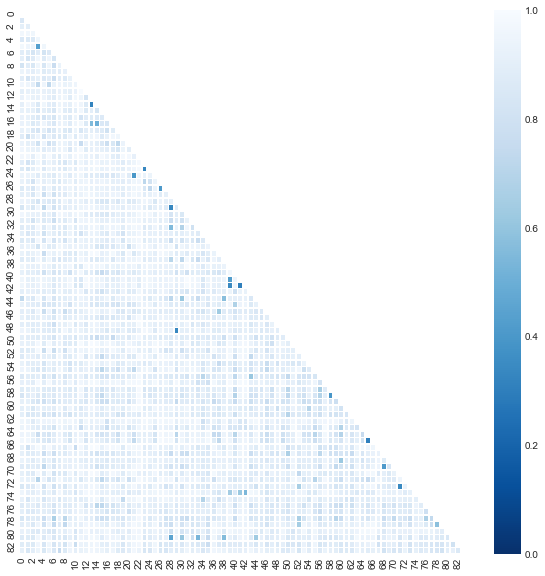


- Mean variance in prototype selection:  0.8796876271863818

- Final number of prototypes:  84

# Finished in 2.8061 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[50 66 58 ... 73 64 62]
 [ 1  4 32 ...  7 17 42]
 [ 1  7 36 ... 15 19 42]
 ...
 [77 49 37 ... 44 60 66]
 [67 62 39 ... 74 76 77]
 [67 62 39 ... 74 76 77]]

# Finished in 58.813 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[50]  ->  [0, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 609, 611, 612, 613, 614, 615, 1062, 1065, 1068, 1069, 1075, 1077, 1078, 1079, 1081, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1122, 1126, 1127, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1166]
[62]  ->  [1, 19, 20,

[0, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 609, 611, 612, 613, 614, 615, 1062, 1065, 1068, 1069, 1075, 1077, 1078, 1079, 1081, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1122, 1126, 1127, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1166]
[1, 19, 20, 21, 22, 23, 24, 26, 27, 32, 35, 36, 44, 45, 46, 51, 63, 64, 65, 66, 67, 68, 69, 70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 175, 176, 177, 178, 179, 180, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,

In [14]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 0.3                 # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize= 70                             # Vector size for WTA algo
number_of_permutations = 1                 # WTA number of permutations


# Similarity evaluation
similarityVectors='initial'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors


start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### CORA: Best Edit distance execution

In [ ]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = False                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 120                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 50                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'edit'  # Embedding metric

# WTA algorithm
windowSize= 37                             # Vector size for WTA algo
number_of_permutations = 10                 # WTA number of permutations


# Similarity evaluation
similarityVectors='initial'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors


start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### Grid search each section

#### GridSearch function

In [ ]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars,prototypeFilter,earlyStop):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'prototypesFilterThr',"protSelectionVariance",'numOfPrototypes','numOfBuckets','averageBucketSize','Accuracy','Precision','Recall','F1','Time'])
    i=1
    for n1 in tqdm(max_numberOf_clusters):
        for n2 in (max_editDistance):
            for n3 in (similarityThreshold):
                for n4 in (windowSize):
                    for n5 in (metric):
                        for n6 in (similarityVectors):
                            for n7 in (distanceMetricEmbedding):
                                for n8 in (distanceMetric):
                                    for n9 in (number_of_permutations):
                                        for n10 in (withchars):
                                            for n11 in (withchars):
                                                for n12 in (prototypeFilter):
                                                    print("+ ------------  ",i,"   ------------- +")
                                                    print('max_numberOf_clusters: ',n1)
                                                    print('max_editDistancez: ',n2)
                                                    print('similarityThreshold: ',n3)
                                                    print('windowSize: ',n4)
                                                    print('metric: ',n5)
                                                    print('similarityVectors: ',n6)
                                                    print('distanceMetricEmbedding: ',n7)
                                                    print('distanceMetric: ',n8)
                                                    print('number_of_permutations: ',n9)
                                                    print('withchars: ',n10)
                                                    print('ngramms: ',n11)
                                                    print('prototypeFilter: ',n12)
                                                    print("+ ----------------------------------- +")
                                                    start = time.time()
                                                    model = RankedWTAHash(
                                                      earlyStop = earlyStop,
                                                      max_numberOf_clusters= n1,
                                                      max_editDistance= n2,
                                                      windowSize= n4,
                                                      similarityThreshold= n3,
                                                      maxOnly= False,
                                                      metric=n5,
                                                      similarityVectors=n6,
                                                      number_of_permutations = n9,
                                                      distanceMetric= n8,
                                                      distanceMetricEmbedding = n7,
                                                      jaccard_withchars = n10,
                                                      ngramms= n11,                                                      
                                                      prototypesFilterThr = n12
                                                    )
                                                    model = model.fit(data)
                                                    exec_time = time.time() - start
                                                    if model.earlyStop==0:                                            
                                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                                        for key in model.buckets.keys():
                                                            tempListmodel.buckets[key]
                                                        averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                        numOfBuckets=len(model.buckets.keys())
                                                    else:
                                                        if model.earlyStop == 3:
                                                            acc = f1 = precision = recall = 'Not counted'
                                                            averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                            numOfBuckets=len(model.buckets.keys())
                                                        else:
                                                            numOfBuckets = averageBucketSize = acc = f1 = precision = recall = 'Not counted'
                                                    i+=1
                                                    results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n12,model.selectionVariance,model.selected_numOfPrototypes,numOfBuckets,averageBucketSize,acc,precision,recall,f1,exec_time]
    now = datetime.now()
    current_time = now.strftime("%H_%M_%S")
    results_dataframe.to_pickle(str(current_time)+".pkl")
    
    return results_dataframe

#### __[i]__ __Prototype selection__


First of all, we need to find some ways on evaluating the prototype selection algorithm. Vantage Spaces are not something new, but we need to examine its behaviour on CORA dataset.

Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Ways to evaluate the algorithm:

- Mean distance between selected prototypes
- Show a HeatMap of consisted of the distances
- Use a PCA after embeddings made and check selected prototypes 
- Some greedy search on the parameters. Parameters to fine tunne:
    -  ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
    -  ```max_editDistance```:  The threshold for the triangle inequality
    -  ```distanceMetric```:  Distance metric between the vectors when creating the space
    -  ```prototypesFilterThr```: Prototypes must differ more that threshold
- __Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    - k is a kernel function that measures the similarity of two points
    - m is the number of prototypes 
    - n is the number of data points x in our original dataset. 
    - The prototypes z are a selection of data points x. 
    
    Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.    


All these parameters will be tested both for edit distance and jaccard with 3-grams.

In [ ]:
def MMD2(k, x, z):
    
    


In [ ]:
max_numberOf_clusters= [500,1000,2000,5000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']

results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

In [ ]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=True).head(50)

##### Remarks

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### [ii] Fine tunning  __Embedding phase__

At the end, when the model will be fine tunned alltogether

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Model final fine tunning


##### Edit distance

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_editDistance= [50,100]
prototypesFilterThr = [20,40,70]

distanceMetric= ['edit']

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['l_inf','euclidean']

windowSize= [16,32,64,128]
number_of_permutations = [1,4,8]

similarityThreshold= [0.7,0.75,0.8]
similarityVectors= ['initial','ranked']
metric= ['kendal','customKendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=0
)

In [ ]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

##### Jaccard

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_jacDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [3]  
jaccard_withchars = [True] 

distanceMetricEmbedding = ['euclidean','euclid_jaccard']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_jacDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

### Performance details

#### Embeddings

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)